In [3]:
from pycocotools.coco import COCO
import nltk
from data_loader import get_loader
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nltk.download("punkt")

# Define a transform to pre-process the training images.
transform_train = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Path to cocoapi dir
cocoapi_dir = "/root/project3/COCO2014"

# Obtain the data loader.
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=False,
    cocoapi_loc=cocoapi_dir,
)


print(batch_size)
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print("sampled indices:", indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

# Obtain the batch.
images, captions = next(iter(data_loader))

print("images.shape:", images.shape)
print("captions.shape:", captions.shape)

# Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/root/project3/COCO2014/annotations_DCC/captions_no_caption_rm_eightCluster_train2014.json
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
[0/351134] Tokenizing captions...
[100000/351134] Tokenizing captions...
[200000/351134] Tokenizing captions...
[300000/351134] Tokenizing captions...
loading annotations into memory...
Done (t=0.49s)
creating index...


  0%|          | 689/351134 [00:00<00:50, 6886.95it/s]

index created!
Obtaining caption lengths...


100%|██████████| 351134/351134 [00:46<00:00, 7527.52it/s]


*********
/root/project3/COCO2014/annotations_DCC/captions_no_caption_rm_eightCluster_train2014.json
10
sampled indices: [205979, 133590, 318512, 101451, 58828, 10553, 334576, 344617, 307266, 179673]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 14])


In [3]:
from model import EncoderCNN, DecoderRNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Specify the dimensionality of the image embedding.
image_embed_size = 256

# Initialize the encoder.
encoder = EncoderCNN(image_embed_size)

# Move the encoder to appropriate device.
encoder.to(device)

# Move last batch of images (from Step 2) to GPU if CUDA is available.
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print("type(features):", type(features))
print("features.shape:", features.shape)
print("captions.shape:", captions.shape)

# Check that the encoder satisfies the requirements!
assert type(features) == torch.Tensor, "Encoder output needs to be a PyTorch Tensor."

assert (features.shape[0] == batch_size) and (
    features.shape[1] == image_embed_size
), "The shape of the encoder output is incorrect."



cuda
type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])
captions.shape: torch.Size([10, 14])


In [4]:
len(data_loader.dataset.vocab)

8308

In [5]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

word_embed_size = image_embed_size

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(word_embed_size, hidden_size, vocab_size)

# Move the decoder to proper device.
decoder.to(device)


# Move last batch of captions (from Step 1) to GPU if CUDA is available
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
# outputs[i,j,k] contains the model's predicted score:
# how likely the j-th token in the i-th caption in the batch is the k-th token in the vocabulary.

outputs = decoder(features, captions)  # (bs, cap_length, vocab_size)


print("type(outputs):", type(outputs))
print("outputs.shape:", outputs.shape)

# Check that the decoder satisfies the requirements!
assert type(outputs) == torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (
    (outputs.shape[0] == batch_size)
    and (outputs.shape[1] == captions.shape[1])
    and (outputs.shape[2] == vocab_size)
), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 14, 8308])


# TRAIN

In [6]:
import math
from model import EncoderCNN, DecoderRNN
from data_loader import get_loader
from data_loader_val import get_loader as val_get_loader
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np
from nlp_utils import clean_sentence, bleu_score

%load_ext autoreload
%autoreload 2

In [7]:
# Setting hyperparameters
batch_size = 128  # batch size
vocab_threshold = 5  # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file
embed_size = 256  # dimensionality of image and word embeddings
hidden_size = 512  # number of features in hidden state of the RNN decoder
num_epochs = 3  # number of training epochs
save_every = 1  # determines frequency of saving model weights
print_every = 20  # determines window for printing average loss
log_file = "training_log_DCC.txt"  # name of file with saved training loss and perplexity
# Path to cocoapi dir
cocoapi_dir = "/root/project3/COCO2014"

In [8]:
# Amend the image transform below.
transform_train = transforms.Compose(
    [
        # smaller edge of image resized to 256
        transforms.Resize(256),
        # get 224x224 crop from random location
        transforms.RandomCrop(224),
        # horizontally flip image with probability=0.5
        transforms.RandomHorizontalFlip(),
        # convert the PIL Image to a tensor
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [9]:
# Build data loader.
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.51s)
creating index...


  0%|          | 603/351134 [00:00<00:58, 6027.30it/s]

index created!
Obtaining caption lengths...


100%|██████████| 351134/351134 [00:48<00:00, 7194.60it/s]


*********
/root/project3/COCO2014/annotations_DCC/captions_no_caption_rm_eightCluster_train2014.json


In [10]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initializing the encoder and decoder
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Defining the loss function
criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

# Specifying the learnable parameters of the mode
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Defining the optimize
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoc
total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

In [13]:
# Open the training log file.
f = open(log_file, "w")

for epoch in range(1, num_epochs + 1):
    for i_step in range(1, total_step + 1):

        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_saosmpler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Passing the inputs through the CNN-RNN model
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculating the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        #         # Uncomment to debug
        #         print(outputs.shape, captions.shape)
        #         # torch.Size([bs, cap_len, vocab_size]) torch.Size([bs, cap_len])

        #         print(outputs.view(-1, vocab_size).shape, captions.view(-1).shape)
        #         # torch.Size([bs*cap_len, vocab_size]) torch.Size([bs*cap_len])

        # Backwarding pass
        loss.backward()

        # Updating the parameters in the optimizer
        optimizer.step()

        # Getting training statistics
        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )

        # Print training statistics to file.
        f.write(stats + "\n")
        f.flush()

        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print("\r" + stats)

    # Save the weights.
    if epoch % save_every == 0:
        torch.save(
            decoder.state_dict(), os.path.join("./models_DCC", "decoder-%d.pkl" % epoch)
        )
        torch.save(
            encoder.state_dict(), os.path.join("./models_DCC", "encoder-%d.pkl" % epoch)
        )

# Close the training log file.
f.close()

Epoch [1/3], Step [20/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [40/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [60/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [80/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [100/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [120/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [140/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [160/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [180/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [200/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [220/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [240/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [260/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [280/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [300/2744], Loss: 0.0001, Perplexity: 1.0001
Epoch [1/3], Step [320/2744], Loss: 0.0001, Perplexity: 1.0

In [12]:
epoch = 1
torch.save(
            decoder.state_dict(), os.path.join("./models_DCC", "decoder-%d.pkl" % epoch)
        )

In [14]:
torch.save(decoder.state_dict(), os.path.join('./models_DCC', 'decoder-final.pkl'))
torch.save(encoder.state_dict(), os.path.join('./models_DCC', 'encoder-final.pkl'))

# test data

In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence

%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
cocoapi_dir = "/root/project3/COCO2014"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
data_loader = get_loader(transform=transform_test, mode="test", type = "zebra", cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


torch.Size([1, 427, 640, 3]) torch.Size([1, 3, 224, 224]) torch.Size([427, 640, 3])


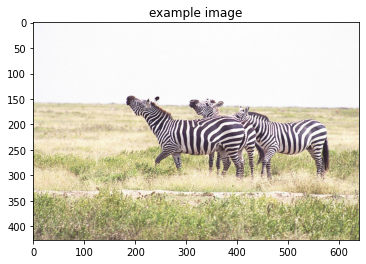

In [10]:
# Obtaining sample image before and after pre-processing. from CoCoDataset
orig_image, image = next(iter(data_loader))

print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Specify the saved models to load.
encoder_file = "encoder-final.pkl"
decoder_file = "decoder-final.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join("./models_DCC", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models_DCC", decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(8308, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8308, bias=True)
)

In [12]:
# Moving image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtaining the embedded image features.
features = encoder(image).unsqueeze(1)

print(features.shape)
# Passing the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print("example output:", output)

assert type(output) == list, "Output needs to be a Python list"
assert all([type(x) == int for x in output]), "Output should be a list of integers."
assert all(
    [x in data_loader.dataset.vocab.idx2word for x in output]
), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 256])
example output: [0, 3, 13, 110, 930, 45, 11, 53, 76, 77, 11, 273, 26, 1]


In [13]:
sentence = clean_sentence(output, data_loader.dataset.vocab.idx2word)
print("example sentence:", sentence)

assert type(sentence) == str, "Sentence needs to be a Python string!"

example sentence:  a man is posing on the beach next to the grass .


In [7]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()
    # remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12, color='white')
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

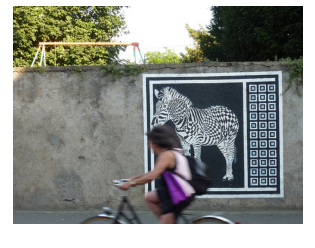

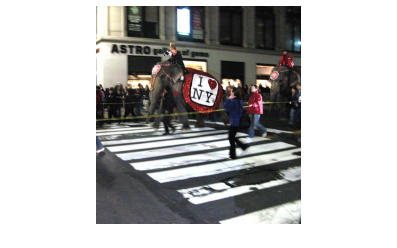

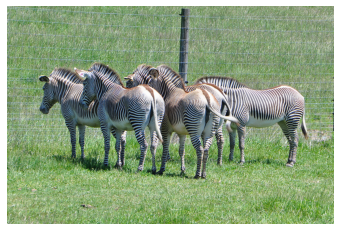

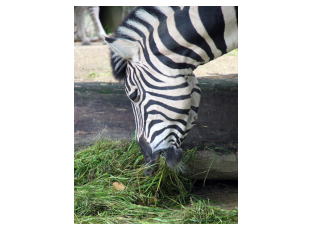

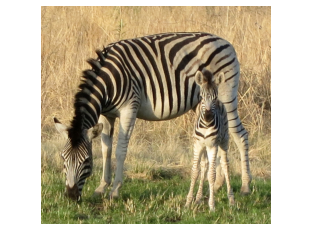

In [17]:
for i in range(5):
    get_prediction(data_loader.dataset.vocab.idx2word, i=i)